In [2]:
import MDAnalysis as mda
atomistic_system = mda.Universe
from modules.distances import *
from modules.dssp import dssp
from modules.input import res_list, show_fasta
from typing import Tuple
%reload_ext autoreload
%autoreload 2
import input
from ipywidgets import IntProgress
from IPython.display import display

In [3]:
atomistic_system, reference_structure, energy_like_terms, is_aligned = input.read_files()
is_aligned = input.align_traj(is_aligned)
show_fasta(atomistic_system)


Aligned file found, reading this instead
Trajectory allready aligned, delete md250ns_center_po_aligned.xtc to rerun alignement
----5----10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95---100--105--110--115--120--125--130--135--140--145--150--155--160--165--170--
TTAPEAPSVNDTEVGSKKVSGKGHEVGNTVTVTFPDGKTATSKVDEKGNWTVDVPEGTELKVGNEITATETDMSGNKSESGKGKVTDTTAPEAPSVNDTEVGSKKVSGKGHEVGNTVTVTFPDGKTATSKVDEKGNWTVDVPEGTELKVGNEITATETDMSGNKSESGKGKVTD
--------E--EE----EEEEE------EEEEE-----EEEEEE----EEEEE-------------EEEEE-----E---EE--EE---------E--E-----EEEEE------EEEEE-----EEEEEE----EEEEE-----------EEEEEEE-----E---EEEEE--


In [4]:
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation

def alignment_error(params, points1, points2):
    """
    Compute alignment error (objective function) for optimization.
    
    params: array-like, parameters to optimize (rotation and translation)
    points1, points2: numpy arrays, 3D point clouds
    """
    rotation = Rotation.from_euler('xyz', params[:3])
    translation = params[3:]
    
    # Apply rotation and translation to points1
    aligned_points1 = rotation.apply(points1) + translation
    
    # Compute sum of squared distances between aligned points1 and points2
    error = np.sum((aligned_points1 - points2) ** 2)
    
    return error

def least_squares_alignment(points1, points2):
    """
    Perform least squares alignment of two 3D point clouds.
    
    points1, points2: numpy arrays, 3D point clouds
    """
    # Initial guess for rotation angles and translation vector
    initial_guess = np.zeros(6)
    
    # Perform optimization to minimize alignment error
    result = minimize(alignment_error, initial_guess, args=(points1, points2))
    
    # Extract optimized rotation and translation parameters
    rotation_params = result.x[:3]
    translation = result.x[3:]
    
    # Convert rotation parameters to Rotation object
    rotation = Rotation.from_euler('xyz', rotation_params)
    
    return rotation, translation

In [5]:

sele_residues_domainA = "(resid 10 to 80) and name CA"
sele_residues_domainB = "(resid 97 to 167) and name CA"

import MDAnalysis.analysis.align as align

reference = atomistic_system.select_atoms(sele_residues_domainA)
aligner = align.AlignTraj(atomistic_system, reference, 
                                select=sele_residues_domainA,
                                in_memory=True)
aligner.run(verbose=True)

  0%|          | 0/25001 [00:00<?, ?it/s]

In [6]:
#domain_aligned_system = mda.Universe(input.sim_path + input.trajectory_file_name.split(".")[0] + "_domain_align.xtc")
print(atomistic_system.select_atoms('resid 10'))

<AtomGroup [<Atom 121: N of type N of resname ASN, resid 10 and segid SYSTEM and altLoc >, <Atom 122: H of type H of resname ASN, resid 10 and segid SYSTEM and altLoc >, <Atom 123: CA of type C of resname ASN, resid 10 and segid SYSTEM and altLoc >, ..., <Atom 132: HD22 of type H of resname ASN, resid 10 and segid SYSTEM and altLoc >, <Atom 133: C of type C of resname ASN, resid 10 and segid SYSTEM and altLoc >, <Atom 134: O of type O of resname ASN, resid 10 and segid SYSTEM and altLoc >]>


In [7]:
clouds_ts = []
f = IntProgress(min=0, max=len(atomistic_system.trajectory)) # instantiate the bar
display(f)
for ts in atomistic_system.trajectory:
    #if atomistic_system.trajectory.time > 50*100:
    #    break
    CAs_A = atomistic_system.select_atoms(sele_residues_domainA).positions
    CAs_B = atomistic_system.select_atoms(sele_residues_domainB).positions
    data = (CAs_A, CAs_B)
    clouds_ts.append(data)
    f.value += 1

IntProgress(value=0, max=25001)

In [8]:
angles = []
from joblib import Parallel, delayed

def get_single_alignement(cloud_pair: tuple):
    rotation, translation = least_squares_alignment(cloud_pair[0], cloud_pair[1])
    euler_angles = rotation.as_euler('zyx', degrees=True)
    return euler_angles

print(f"tasks to run: {len(clouds_ts)}")
#aligned_results = Parallel(n_jobs=-1, verbose=1)(delayed(get_single_alignement)(d) for d in clouds_ts)
aligned_results = Parallel(n_jobs=-1, verbose=1)(delayed(get_single_alignement)(d) for d in clouds_ts)

tasks to run: 25001


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3816 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5516 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7416 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9516 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 11816 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 14316 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 17016 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 19916 tasks    

[array([  34.26389944,  -24.92962912, -111.82172875]), array([  29.27610687,  -31.95077021, -110.17477386]), array([  25.28009662,  -28.29301792, -112.38188281]), array([  25.77043215,  -25.51832678, -110.00700309]), array([  26.20854361,  -22.56050446, -110.55610408]), array([  27.78757274,  -26.28781733, -114.21337354]), array([  24.52996811,  -26.57784848, -119.48529884]), array([  22.41490714,  -27.4428941 , -124.5175784 ]), array([  19.56072358,  -31.12308241, -124.15031189]), array([  18.2127412 ,  -30.69023962, -123.54310142]), array([  25.28711426,  -35.26885423, -119.5986344 ]), array([  27.90884844,  -39.81943291, -119.55268284]), array([  33.59770788,  -40.35811048, -111.6192461 ]), array([  34.06152932,  -39.91431958, -115.51555606]), array([  26.27920436,  -41.27923451, -128.71904021]), array([  25.79179144,  -46.24610548, -129.68122616]), array([  29.08401731,  -45.8112819 , -125.87364327]), array([  32.22242769,  -41.28958657, -127.35855009]), array([  28.86036862,  -39.

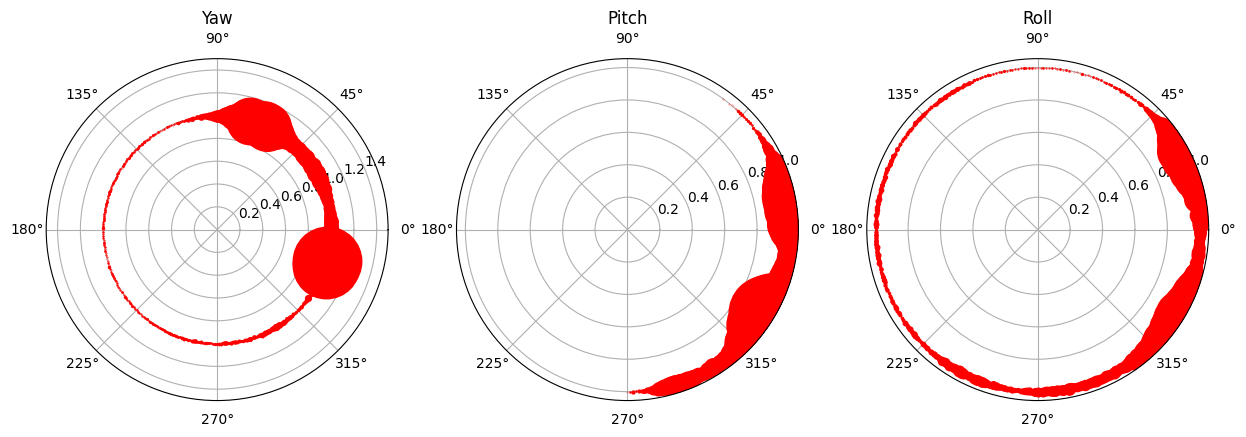

In [14]:
rounded_angles = np.round(aligned_results)
print(aligned_results)
unique_rounded_angles_y, counts_y = np.unique(rounded_angles.T[0], return_counts=True)
unique_rounded_angles_p, counts_p = np.unique(rounded_angles.T[1], return_counts=True)
unique_rounded_angles_r, counts_r = np.unique(rounded_angles.T[2], return_counts=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': 'polar'})
# Plot the rotation angles
for i, angle in enumerate(unique_rounded_angles_y):
    axs[0].plot(np.radians(angle), 1,  marker='o', markersize=counts_y[i]/10, color='r', linestyle='None')
    axs[0].set_title('Yaw')
    axs[0].set_rmax(1.5)  # Set the maximum radius of the plot

for i, angle in enumerate(unique_rounded_angles_p):
    axs[1].plot(np.radians(angle), 1,  marker='o', markersize=counts_p[i]/10, color='r', linestyle='None')
    axs[1].set_title('Pitch')
    axs[0].set_rmax(1.5)  # Set the maximum radius of the plot


for i, angle in enumerate(unique_rounded_angles_r):
    axs[2].plot(np.radians(angle), 1,  marker='o', markersize=counts_r[i]/10, color='r', linestyle='None')
    axs[2].set_title('Roll')
    axs[0].set_rmax(1.5)  # Set the maximum radius of the plot

#ax.legend(loc='upper right')
#yaw.set_theta_direction(-1)
#yaw.set_theta_zero_location('N')

plt.show()

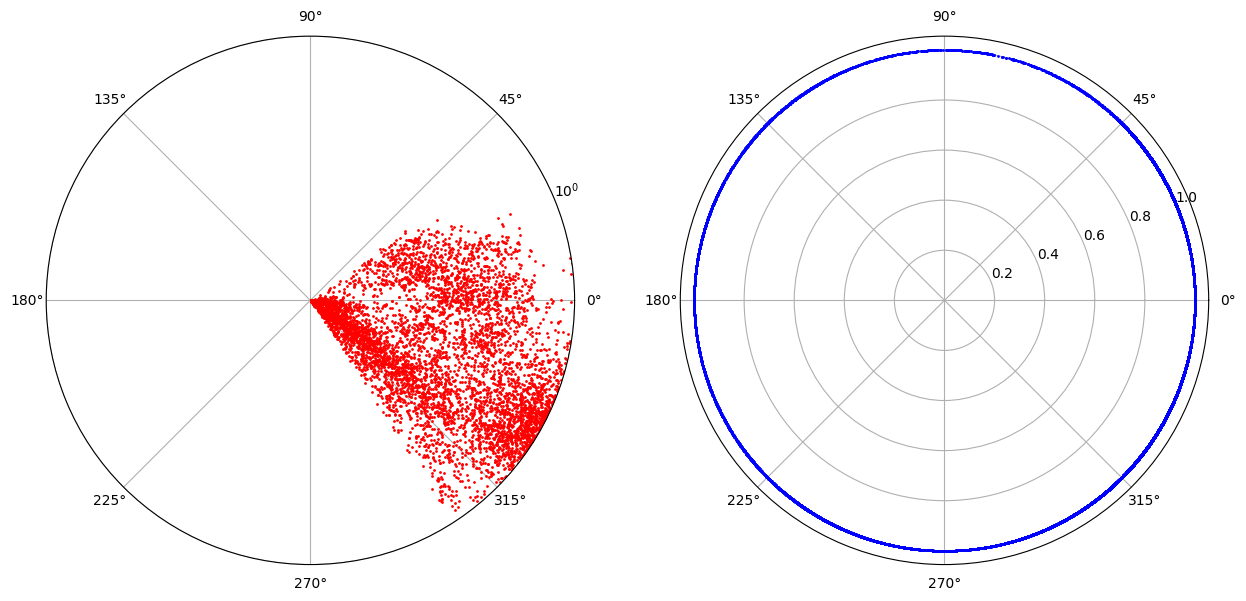

In [13]:
euler_angles = aligned_results


# Polar plot
fig, axs = plt.subplots(1, 2, figsize=(15, 10), subplot_kw={'projection': 'polar'})
axs[0].set_rscale('symlog')

# Convert spherical coordinates to Cartesian coordinates
#x = radius * np.sin(np.radians(inclination)) * np.cos(np.radians(azimuth))
#y = radius * np.sin(np.radians(inclination)) * np.sin(np.radians(azimuth))

# Plot the roll vector

for i, angle in enumerate(euler_angles):
    azimuth = angle[0]
    inclination =angle[1]
    radius = angle[2]
# Plot the yaw/pitch vector
    axs[0].plot(np.radians(azimuth), np.sin(np.radians(inclination)),  'ro', label='Yaw/Pitch',  markersize=1,)
    #axs[0].plot(np.radians(azimuth), np.sin(np.radians(inclination)),  'ro', label='Yaw/Pitch',  markersize=1,)
    axs[1].plot(np.radians(radius), 1,'bo', label='Roll',markersize=1,)

axs[0].set_rmin(0)
axs[0].set_rmax(1)
#ax.legend(loc='upper right')
#ax.set_theta_direction(-1)
#ax.set_theta_zero_location('N')


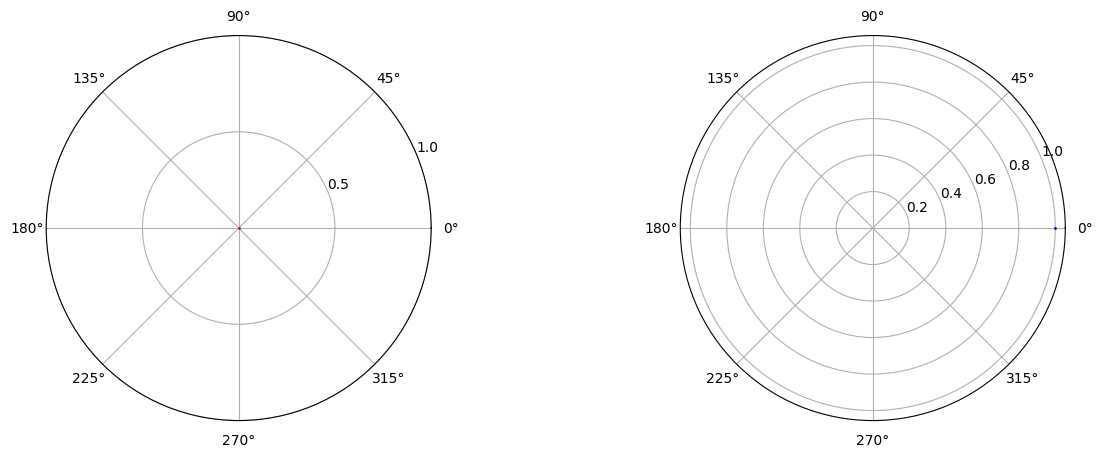

In [ ]:

azimuth = 0
inclination = 0
radius = 0

fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': 'polar'})
# Plot the yaw/pitch vector
axs[0].plot(np.radians(azimuth), np.sin(np.radians(inclination)),  'ro', label='Yaw/Pitch',  markersize=1,)
axs[0].set_rticks([0.5, 1])
axs[0].set_rmin(0)
#axs[0].plot(np.radians(azimuth), np.sin(np.radians(inclination)),  'ro', label='Yaw/Pitch',  markersize=1,)
axs[1].plot(np.radians(radius), 1,'bo', label='Roll',markersize=1,)